# Flawed steel cased well in a layered space

[Lindsey Heagy](http://github.com/lheagy)

This notebook examines how the presence of a conductive or resistive layer impacts our ability to detect a flaw in the well. 

This notebook was used to produce Figures 7 and 8 in Heagy and Oldenburg, 2018. 

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
import ipywidgets
from string import ascii_lowercase

import discretize
from discretize import utils
from SimPEG import Utils, Maps, Versions
from SimPEG.Survey import Data
from pymatsolver import Pardiso


import casingSimulations as casingSim

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 14

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $5\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In [3]:
simDir = "dc_flaw_w_layer"

In [4]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

model = casingSim.model.FlawedCasingInSingleLayer(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    layer_z = np.r_[-450, -400],  # 50m thick layer
    src_a = np.r_[0., 3*np.pi/2., -1.25],  # put the A electrode just below the surface
    src_b = np.r_[1*casing_l, 3*np.pi/2., -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, 3*np.pi/2., -1.25] 

In [5]:
model.serialize()

{'filename': 'ModelParameters.json',
 'directory': 'dc_flaw_w_layer',
 'version': '0.0.7',
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'mur_casing': 1.0,
 'mur_inside': 1.0,
 'casing_top': 0.0,
 'casing_l': 1000.0,
 'casing_d': 0.09000000000000001,
 'casing_t': 0.01,
 'flaw_r': [0.0, 0.0],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [0.0, 0.0],
 'sigma_flaw': 5500000.0,
 'mur_flaw': 1.0,
 'sigma_back': 0.1,
 'mur_back': 1.0,
 'sigma_air': 0.0001,
 'surface_z': 0.0,
 'sigma_layer': 0.01,
 'layer_z': [-450, -400],
 'src_a': [0.045000000000000005, 4.71238898038469, -1.25],
 'src_b': [1000.0, 4.71238898038469, -1.25],
 '__class__': 'FlawedCasingInSingleLayer'}

In [6]:
experiment = 1  # 1000 m well, break at 500m, compare with short well

In [7]:
copiedmodelparams = {
    key: val for key, val in model.serialize().items() if key in dir(casingSim.model.CasingInSingleLayer) and not key.startswith('_') 
}

In [8]:
background = casingSim.model.CasingInSingleLayer(
    **copiedmodelparams
)

### Set up the models

In [9]:
flaw_depth = 500.

In [10]:
model.flaw_r = np.r_[model.casing_a, model.casing_b]
model.flaw_z = np.r_[-10, 0] - flaw_depth
model.sigma_flaw = model.sigma_back

In [11]:
sigma_layer = [1e-3, 1e-2, 1e-1, 1, 10]

flawed_models = {}
baseline_models = {}

for sig in sigma_layer:
    tmp_flawed = model.copy()
    tmp_flawed.sigma_layer = sig

    tmp_baseline = background.copy()
    tmp_baseline.sigma_layer = sig

    flawed_models['flaw_{}'.format(sig)] = tmp_flawed
    baseline_models['baseline_{}'.format(sig)] = tmp_baseline

In [12]:
baseline_models

{'baseline_0.001': <casingSimulations.model.CasingInSingleLayer at 0x1138f6710>,
 'baseline_0.01': <casingSimulations.model.CasingInSingleLayer at 0x109659d68>,
 'baseline_0.1': <casingSimulations.model.CasingInSingleLayer at 0x125d8c0f0>,
 'baseline_1': <casingSimulations.model.CasingInSingleLayer at 0x125d8c358>,
 'baseline_10': <casingSimulations.model.CasingInSingleLayer at 0x125d8c780>}

In [13]:
flawed_models

{'flaw_0.001': <casingSimulations.model.FlawedCasingInSingleLayer at 0x1138f65c0>,
 'flaw_0.01': <casingSimulations.model.FlawedCasingInSingleLayer at 0x109659390>,
 'flaw_0.1': <casingSimulations.model.FlawedCasingInSingleLayer at 0x125d8c048>,
 'flaw_1': <casingSimulations.model.FlawedCasingInSingleLayer at 0x125d8c278>,
 'flaw_10': <casingSimulations.model.FlawedCasingInSingleLayer at 0x125d8c6a0>}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [14]:
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(16)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [15]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 50.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/Users/lindseyjh/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


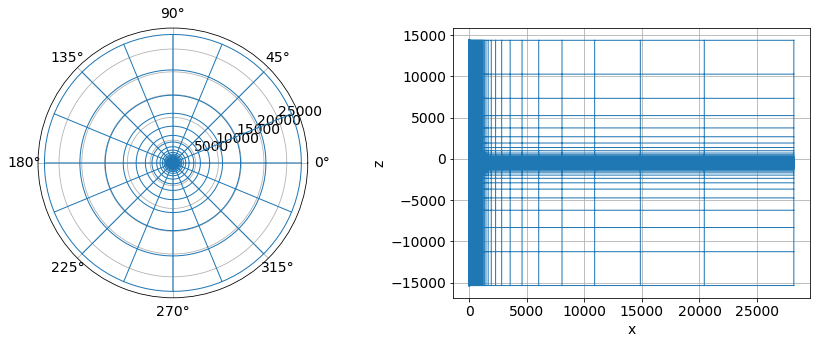

In [16]:
cylMeshGen.mesh.plotGrid()

In [17]:
src_theta = cylMeshGen.hy[0]/2. + np.pi
model.src_a[1] = src_theta
model.src_b[1] = src_theta

(0.0, 3000.0)

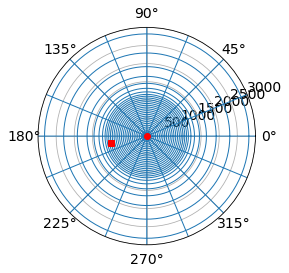

In [18]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [19]:
# put the models in a dictionary for convienence 
modelDict = baseline_models
modelDict.update(flawed_models)
model_names = sorted(baseline_models.keys())
print(model_names)

['baseline_0.001', 'baseline_0.01', 'baseline_0.1', 'baseline_1', 'baseline_10', 'flaw_0.001', 'flaw_0.01', 'flaw_0.1', 'flaw_1', 'flaw_10']


In [20]:
for mod in modelDict.values():
    mod.src_a[1] = src_theta
    mod.src_b[1] = src_theta

In [21]:
# Assign physical properties on the mesh
physpropsDict = dict(
    [
        (name, casingSim.model.PhysicalProperties(cylMeshGen, mod)) 
        for name, mod in modelDict.items()
    ]
)

In [22]:
model_names

['baseline_0.001',
 'baseline_0.01',
 'baseline_0.1',
 'baseline_1',
 'baseline_10',
 'flaw_0.001',
 'flaw_0.01',
 'flaw_0.1',
 'flaw_1',
 'flaw_10']

In [23]:
modelDict[model_names[0]].serialize()

{'filename': 'ModelParameters.json',
 'directory': 'dc_flaw_w_layer',
 'version': '0.0.7',
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'mur_casing': 1.0,
 'mur_inside': 1.0,
 'casing_top': 0.0,
 'casing_l': 1000.0,
 'casing_d': 0.09000000000000001,
 'casing_t': 0.01,
 'sigma_back': 0.1,
 'mur_back': 1.0,
 'sigma_air': 0.0001,
 'surface_z': 0.0,
 'sigma_layer': 0.001,
 'layer_z': [-450.0, -400.0],
 'src_a': [0.045000000000000005, 3.3379421944391554, -1.25],
 'src_b': [1000.0, 3.3379421944391554, -1.25],
 '__class__': 'CasingInSingleLayer'}

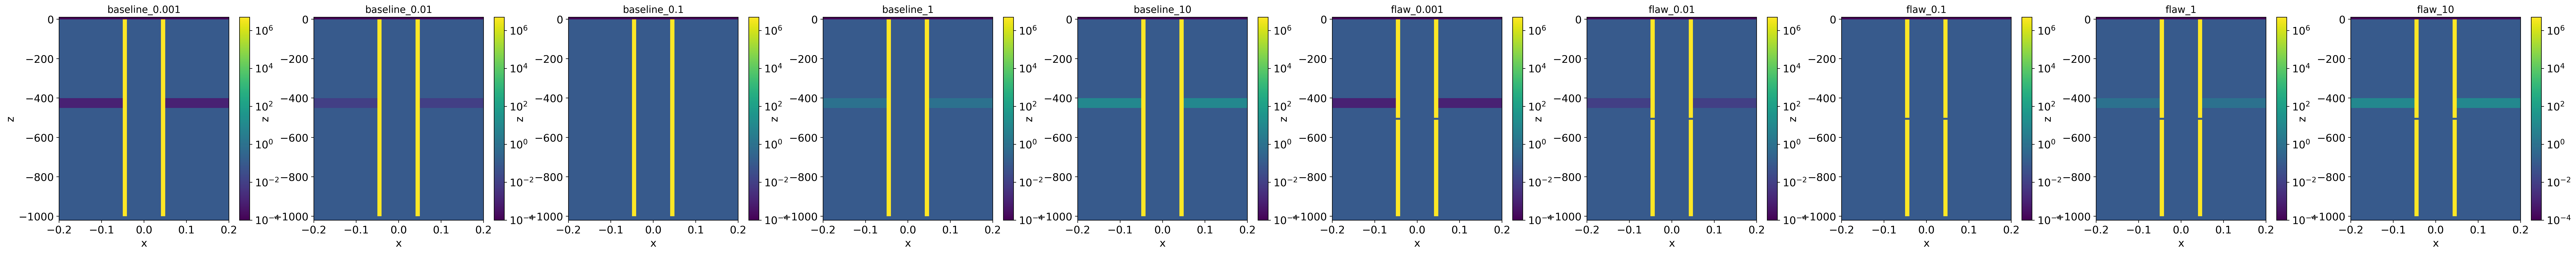

In [24]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l -20, 10]
    

theta_ind = 10

plot_models = model_names

fig, ax = plt.subplots(1, len(plot_models), figsize=(6*len(plot_models), 5), dpi=350)
for a, title in zip(ax, plot_models):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        theta_ind=theta_ind,
        pcolorOpts={'norm':LogNorm()},  # plot on a log-scale
#         clim = np.r_[1e-6, 1e2]
    )
    a.set_title('{}'.format(title), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [25]:
model.src_a, model.src_b

(array([ 0.045     ,  3.33794219, -1.25      ]),
 array([1000.        ,    3.33794219,   -1.25      ]))

In [26]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_locs = [500]

src_b = np.vstack(
    [[loc, model.src_b[1], model.src_b[2]] for loc in src_locs]
)

src_a = np.ones((src_b.shape[0], 1)) * model.src_a

In [27]:
src_b

array([[500.        ,   3.33794219,  -1.25      ]])

## set up a DC simulation

In [28]:
# model_names = ["baseline", "flawed"]

In [29]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=modelDict[key], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [30]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run(save=False)
    print('\n')

--- Running baseline_0.001 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 19.386795043945312


--- Running baseline_0.01 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 34.02718472480774


--- Running baseline_0.1 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 28.732895135879517


--- Running baseline_1 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <

## Plot Results 

In [31]:
from SimPEG import DC

In [32]:
rx_r = cylMeshGen.mesh.vectorCCx[(cylMeshGen.mesh.vectorCCx > 2) & (cylMeshGen.mesh.vectorCCx < 2600)]
rx_y = np.r_[cylMeshGen.mesh.vectorCCy[3]]
rx_z = np.r_[-1.25]
rx = DC.Rx.Pole(utils.ndgrid(rx_r, rx_y, rx_z))

In [33]:
for m in model_names:
    srcList=simDict[m].survey.srcList
    for src in srcList: 
        src.rxList = [rx]

In [34]:
# %%time

# data_dict = {}
# for key in model_names:
#     model = physpropsDict[key].model
#     simDict[key].prob.model = model
#     data_dict[key] = Data(simDict[key].survey, simDict[key].survey.dpred(model, f=fieldsDict[key]))

In [35]:
# for key in model_names:
#     simDict[key].survey.dobs = data_dict[key].tovec()

### View Fields, Fluxes, and Charges
This is a widget for interrogating the results.

- `max_r`: maximum radial extent of the plot (m)
- `min_depth`: minimum depth (m)
- `max_depth`: maximum depth (m)
- `clim_min`: minimum colorbar limit. If 0, then the colorbar limits are the plotting defaults
- `clim_max`: maximum colorbar limit. If 0, then the colorbar limits are the plotting defaults
- `model_key`: model which we are viewing
- `view`: field or physical property that is plotted
- `prim_sec`: primary plots the baseline (intact well), secondary subtracts the primary response from the current value (note that if you select baseline and secondary the value will be zero and an error thrown)
- `show_mesh`: if checked, the mesh will be plotted on the right hand half of the plot
- `casing_outline`: draws the outline of the casing

In [36]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names
)

In [37]:
viewer.widget_cross_section(defaults={"min_depth":0, "max_depth":casing_l*1.25})

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=0.0, description='min_depth')…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [38]:
viewer.widget_depth_slice(defaults={"z_ind": 426, 'view': 'e', 'max_r':500})

interactive(children=(FloatText(value=500.0, description='max_r'), FloatText(value=0.0, description='clim_min'…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Plot Charges

In [39]:
mesh = cylMeshGen.mesh

In [40]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="baseline"
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    
    if secondary is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        plotme = plotme - f_prim[src_prim, 'charge']
    z_charges, charges = casingSim.casing_charges(plotme, mesh, mod)
    ax.plot(
        -z_charges, charges/csz, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle
    )
        

In [41]:
conductivities = sorted(set([float(m.split("_")[-1]) for m in model_names]))
conductivities

[0.001, 0.01, 0.1, 1.0, 10.0]

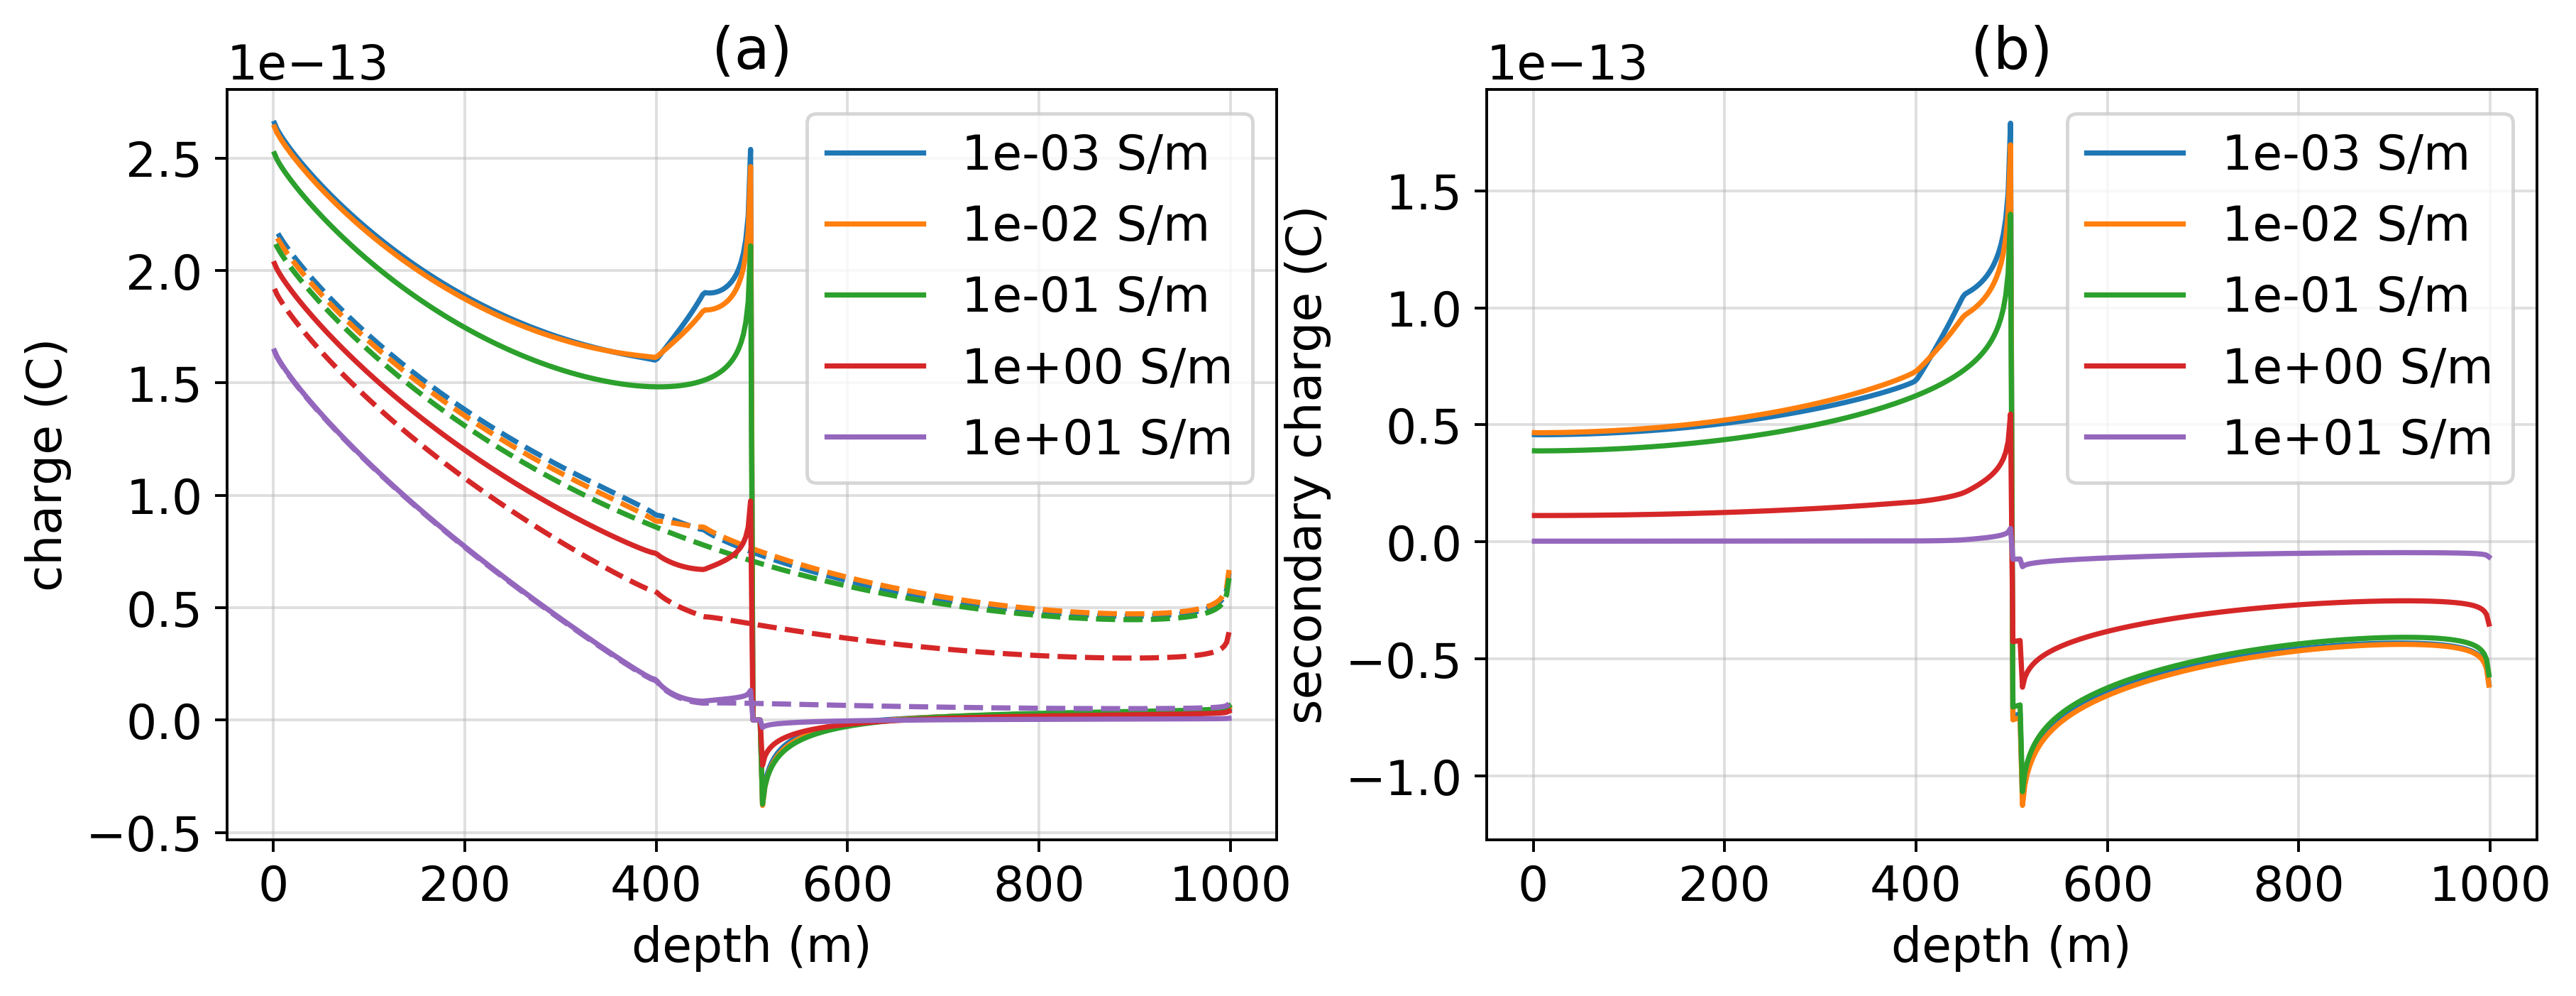

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi = 350)

for i, sigma in enumerate(conductivities):
    key = "flaw_{}".format(sigma if sigma < 1 else int(sigma))
    baseline_key = "baseline_{}".format(sigma if sigma < 1 else int(sigma))
    label = "{:1.0e} S/m".format(sigma)
    # total
    plot_charge(
        ax=ax[0], key=baseline_key, color_ind=i, 
        src_ind=len(srcList)-1, secondary=False,
        linestyle='--'
    )
    plot_charge(
        ax=ax[0], key=key, color_ind=i, 
        src_ind=len(srcList)-1, label=label, secondary=False
    )
    
    # secondary 
    plot_charge(
        ax=ax[1], key=key, color_ind=i, 
        src_ind=len(srcList)-1, secondary=True,
        primary_key=baseline_key, label=label
    )

for i, a in enumerate(ax):
    a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge (C)' if i == 0 else 'secondary charge (C)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)

fig.savefig('../figures/casing_charge_layer', dpi=350, bbox_inches="tight")
fig.savefig('../arxiv-figures/casing_charge_layer', dpi=150, bbox_inches="tight")

### Plot fields, fluxes and charges

In [43]:
from matplotlib import rcParams, ticker
rcParams['font.size'] = 14

In [44]:
model_names

['baseline_0.001',
 'baseline_0.01',
 'baseline_0.1',
 'baseline_1',
 'baseline_10',
 'flaw_0.001',
 'flaw_0.01',
 'flaw_0.1',
 'flaw_1',
 'flaw_10']

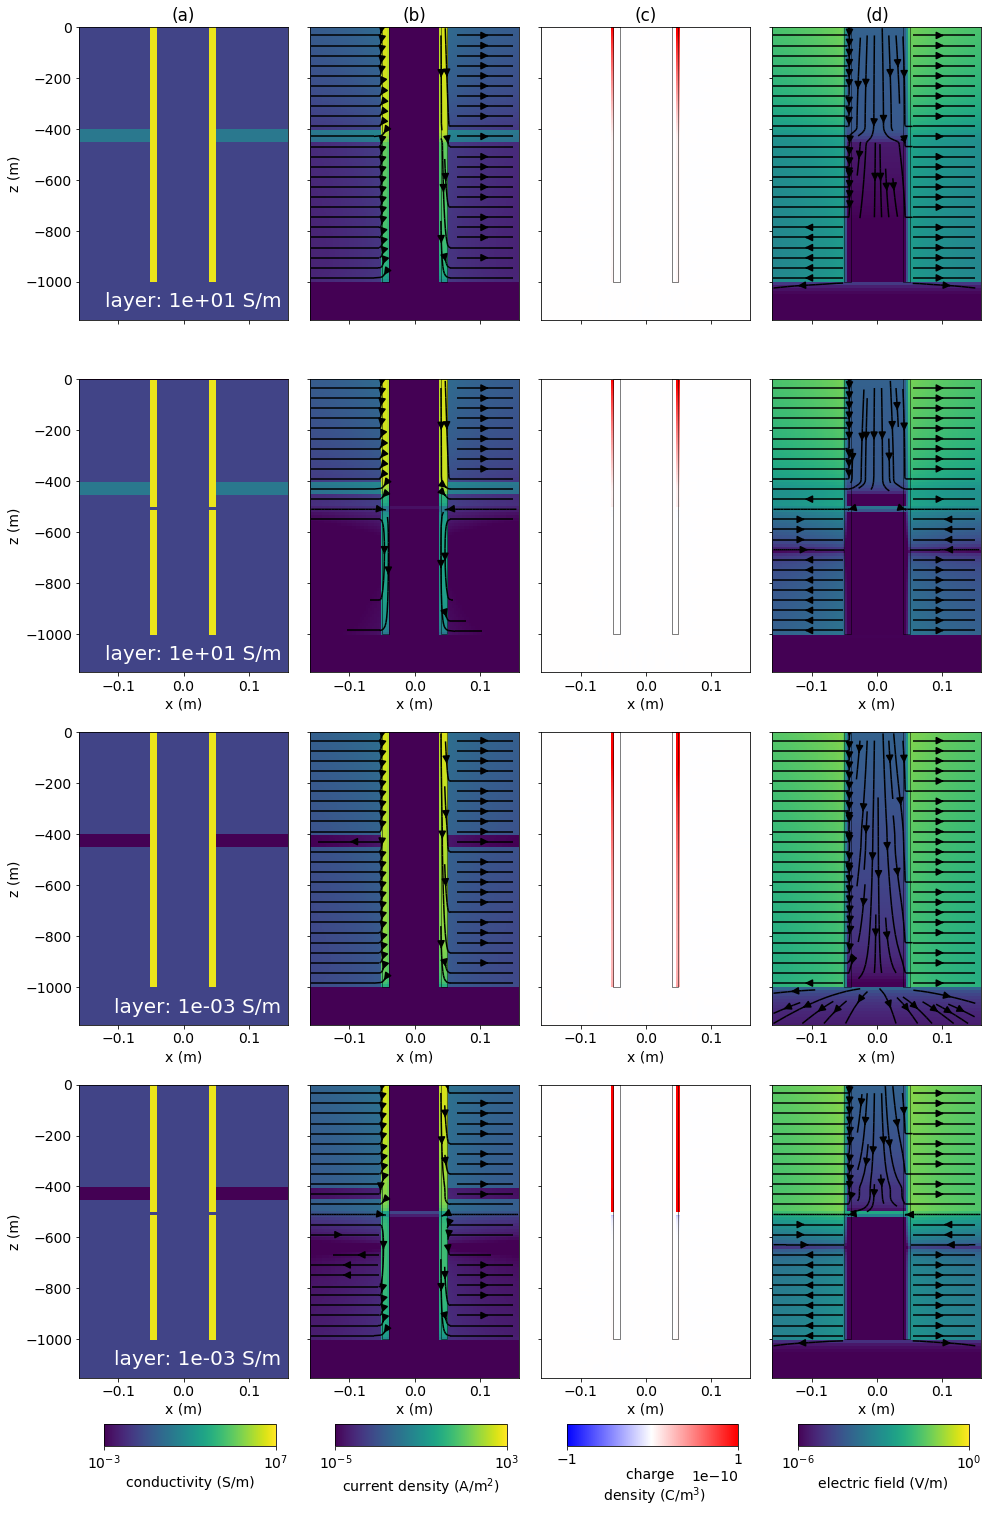

In [45]:
fig, ax = plt.subplots(4, 4, figsize=(4*3.5, 4*5))
fig.subplots_adjust(bottom=0.1)

# key_bottom = "flaw_0.001"
# key_top = "flaw_10"
keys = ["baseline_10", "flaw_10", "baseline_0.001", "flaw_0.001"]
src_ind = 0

max_r = 0.16
min_depth = 0
max_depth = 1150

zlim = np.r_[-max_depth, -min_depth]
xlim = max_r * np.r_[-1., 1.]
stream_opts = {"color":"k", "arrowsize":1.5}

for i, key in enumerate(keys):
    
    sigma_out = viewer.plot_cross_section(
        ax=ax[i][0], 
        clim=np.r_[1e-3, 1e7],
        xlim=xlim, 
        zlim=zlim,
        view='sigma', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=False,
        stream_opts=stream_opts
    )
    ax[i][0].text(
        max_r - 0.01, -max_depth+50, 
        "layer: {:1.0e} S/m".format(float(key.split("_")[-1])), 
        color='w', fontsize=20, horizontalalignment="right"
    )
    
    
    currents_out = viewer.plot_cross_section(
        ax=ax[i][1], 
        clim= np.r_[1e-5, 1e3],
        xlim=xlim, 
        zlim=zlim,
        view='j', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    charge_out = viewer.plot_cross_section(
        ax=ax[i][2], 
        clim=1e-10 * np.r_[-1, 1],
        xlim=xlim, 
        zlim=zlim,
        view='charge_density', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        stream_opts=stream_opts
    )
    
    efields_out = viewer.plot_cross_section(
        ax=ax[i][3], 
        clim= np.r_[1e-6, 1],
        xlim=xlim, 
        zlim=zlim,
        view='e', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    
    if i == 0: 
        for j, a in enumerate(ax[i]):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            a.set_ylabel('z (m)')
            a.set_title('({})'.format(ascii_lowercase[j]))
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    else:
        for j, a in enumerate(ax[i]):
            a.set_xlabel('x (m)')
            a.set_title('')
            a.set_ylabel('z (m)')
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    
# cbar_ax = fig.add_axes([0.25, -0.01, 0.11, 0.01])
# cb_charge = fig.colorbar(charge_out[0], ax=cbar_ax, orientation='horizontal')
        
plt.tight_layout()

for i, out, label in zip(
    np.arange(4), 
    [sigma_out, currents_out, charge_out, efields_out],
    ['conductivity (S/m)', 'current density (A/m$^2$)', 'charge \n density (C/m$^3$)', 'electric field (V/m)'],
#     [None, None, 'min', 'min']
):
    x = ax[1][i].figbox.corners()[0, 0]
    cbar_ax = fig.add_axes([x+0.025, -0.01, 0.17, 0.015])
    cb = fig.colorbar(
        out[0], cbar_ax, orientation="horizontal"
    )
    cb.set_label(label)
    cb.set_ticks([cb.vmin, cb.vmax])
    cb.update_ticks()

plt.show() 

fig.savefig('../figures/integrity_layer_physics', bbox_inches="tight", dpi=350)
fig.savefig('../arxiv-figures/integrity_layer_physics', bbox_inches="tight", dpi=150)

## Electric fields at the surface

In [46]:
from string import ascii_lowercase

In [47]:
conductivities = sorted(set([float(m.split("_")[-1]) for m in model_names]))
conductivities

[0.001, 0.01, 0.1, 1.0, 10.0]

In [48]:
import matplotlib.lines as mlines

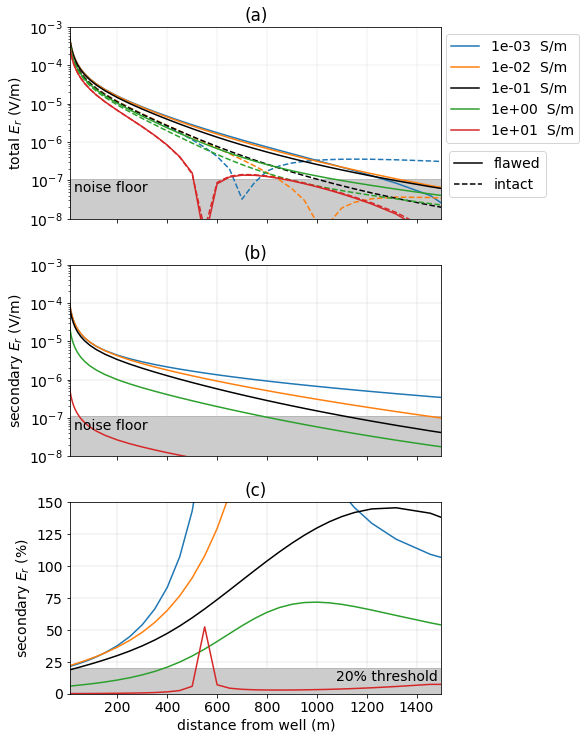

In [50]:
fig, ax = plt.subplots(3, 1, figsize = (6.5, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 0
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 150]
theta_ind = 4

noise_floor = 1e-7
min_percent = 20

eps = 1e-8

unit = " S/m"

for i, sigma, color_ind in zip(range(len(conductivities)), conductivities, [0, 1, 0, 2, 3]): 
    
    key = "flaw_{}".format(sigma if sigma < 1 else int(sigma))
    baseline_key = "baseline_{}".format(sigma if sigma < 1 else int(sigma))
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict[baseline_key].survey.srcList[src_ind]
    label="{:1.0e} {}".format(float(sigma), unit)

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=color_ind if sigma != sigma_back else None, 
        color="k" if sigma == sigma_back else None
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(fieldsDict[baseline_key][baseline_src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind, 
        color_ind=color_ind if sigma != sigma_back else None, 
        color="k" if sigma == sigma_back else None, linestyle="--"
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, 
        label=label, color_ind=color_ind if sigma != sigma_back else None,
        color="k" if sigma == sigma_back else None
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
            (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+eps)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, 
        label=label, color_ind=color_ind if sigma != sigma_back else None,
        color="k" if sigma == sigma_back else None
    )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
        
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-10, "{}% threshold".format(min_percent), ha="right")  

plt.tight_layout()

ax[0].legend(bbox_to_anchor=(1.39, 1))
ax[1].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='flawed'),
        mlines.Line2D([], [], color='k', linestyle='--', label='intact'), 
    ], bbox_to_anchor=[1.3, 1.63]
)

fig.savefig('../figures/integrity_layer', bbox_inches="tight", dpi=350)
fig.savefig('../arxiv-figures/integrity_layer', bbox_inches="tight", dpi=150)

In [2]:
Versions()